In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

#4주차 과제

# 0. 전체 코드만(텍스트 제외) 필사하라.

In [42]:
#과제 피드백
x = np.array([np.random.normal(2,2) for i in range(10000)])
y = np.array(x*2)
print("y: ", np.mean(y), "x: ", np.mean(x))

y:  3.963118454561935 x:  1.9815592272809675


In [43]:
def loss(b_1):
    return sum((y-b_1*x)**2)
#loss함수에서 이야기하는 y와 x는 무슨 변수인가
#y, x 모두 전역변수인데 loss 함수 내에서 지역변수처럼 써버림
#다른 셀에서 x랑 y를 다루고자 할 떄 컴퓨터가 헷갈림
#잘못되진 않았으나 지양하자.

In [44]:
# 이상적인 방향1
#global변수 활용하겠다는 선언
def loss(b_1):
  global x, y
  return sum((y-b_1*x)**2)

# 이상적인 방향 2 (제일 이상적)
def loss(b_1, x, y): #아예 인자로 x, y를 전달. x y로 어떤 값이 들어와도 대응 가능
  return sum((y-b_1*x)**2)

In [45]:
#필요 라이브러리 임포트
#모델
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from xgboost import XGBClassifier #XGBoost
import lightgbm as lgb # LightGBM
from sklearn import tree

In [46]:
#기타
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
import graphviz

In [49]:
titanic = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/titanic.csv")
#타이타닉에 있던 사람들의 신원 정보 데이터셋 - 다른 feature를 보고 생존여부 예측
#age: 평균으로 처리
titanic["Age"] = titanic["Age"].fillna(titanic["Age"].mean())
#cabin은 결측치가 대부분이므로 필요 없을 것 -> 드랍
titanic = titanic.drop(["Cabin"], axis = 1)
titanic["Embarked"] = titanic["Embarked"].fillna(titanic["Embarked"].value_counts().index[0]) #최빈값
titanic["Family Size"] = 0 #family_size라는 열 생성, 0으로 초기화
titanic["Family_Size"] = titanic["Parch"] + titanic["SibSp"] #가족수 계산
titanic["Alone"] = 0 #alone이라는 이진분류용 열 생성, 0으로 초기화
titanic.loc[titanic["Family_Size"]==0, "Alone"] = 1 #Family_size가 0인 사람은 1로 라벨링. 나머지는 여전히 0
# Name, PassengerID, Ticket은 중요하지 않은 변수로 영향 없음
titanic = titanic.drop(["Name", "PassengerId", "Ticket"], axis  = 1)
#sex,embarked 변수는 categorical variable상태 -> 인코딩
from sklearn.preprocessing import LabelEncoder
le_sex = LabelEncoder()
le_sex.fit(titanic["Sex"])
titanic["Sex"] = le_sex.transform(titanic["Sex"])
#male 1 female 0
le_embarked = LabelEncoder()
le_embarked.fit(titanic["Embarked"])
titanic["Embarked"] = le_embarked.transform(titanic["Embarked"])
titanic.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Family Size,Family_Size,Alone
0,0,3,1,22.0,1,0,7.2500,2,0,1,0
1,1,1,0,38.0,1,0,71.2833,0,0,1,0
2,1,3,0,26.0,0,0,7.9250,2,0,0,1
3,1,1,0,35.0,1,0,53.1000,2,0,1,0
4,0,3,1,35.0,0,0,8.0500,2,0,0,1


In [50]:
X = titanic.drop(["Survived"], axis = 1)
y = titanic["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
#712개의 데이터가 training, 179개 데이터가 test

(712, 10) (179, 10) (712,) (179,)


In [51]:
#어떤 모델이든 그 성능을 여러 지표로 평가해 보여주는 함수
def evaluate_metrics(model, X_test, y_test):
  y_hat = model.predict(X_test)
  print("Confusion matrix: ", confusion_matrix(y_test, y_hat), "\n")
  print("Accuracy: ", accuracy_score(y_test, y_hat), "\n")
  print("Precision: ", precision_score(y_test, y_hat), "Recall: ", recall_score(y_test, y_hat), "\n")
  print("F1 score: ", f1_score(y_test, y_hat), "\n")

In [52]:
#하이퍼 파라미터 튜닝을 SVM으로 해보자
#조정하고 싶은 하이퍼파라미터는 kernel, C, gamma 세 개.
#하이퍼파라미터 뭉치는 딕셔너리와 리스트를 결합해서 생성
#이들을 조합하는 경우의수를 모두 연산해야 하니 조금 시간이 많이 걸릴 것
#tqdm은 반복문에 감싸서 그 반복문의 연산 시간을 계산하는 메소드
from tqdm import tqdm
hparams = {"kernel" : ["linear", "poly", "rbf", "sigmoid"], "C" : [0.01, 0.1, 0.2, 0.5, 1.0]}
for kernel in tqdm(hparams['kernel']):
  for c in hparams["C"]:
    svc = svm.SVC(kernel = kernel, C = c) 
    svc.fit(X_train, y_train) 
    y_pred = svc.predict(X_test)
    print("kernel:", kernel, "C:", c,  "Score:", accuracy_score(y_test, y_pred))

#어떤 kernel과 C의 조합이 가장 적절한지 판단 가능
#아래결과 바탕으로 kernel: linear, C:0.01이 좋을 듯

  0%|          | 0/4 [00:00<?, ?it/s]

kernel: linear C: 0.01 Score: 0.7988826815642458
kernel: linear C: 0.1 Score: 0.7988826815642458
kernel: linear C: 0.2 Score: 0.7988826815642458
kernel: linear C: 0.5 Score: 0.7988826815642458


 50%|█████     | 2/4 [00:04<00:04,  2.07s/it]

kernel: linear C: 1.0 Score: 0.7988826815642458
kernel: poly C: 0.01 Score: 0.6145251396648045
kernel: poly C: 0.1 Score: 0.6201117318435754
kernel: poly C: 0.2 Score: 0.6201117318435754
kernel: poly C: 0.5 Score: 0.6256983240223464
kernel: poly C: 1.0 Score: 0.6312849162011173
kernel: rbf C: 0.01 Score: 0.5977653631284916


 75%|███████▌  | 3/4 [00:05<00:01,  1.20s/it]

kernel: rbf C: 0.1 Score: 0.6759776536312849
kernel: rbf C: 0.2 Score: 0.7039106145251397
kernel: rbf C: 0.5 Score: 0.7039106145251397
kernel: rbf C: 1.0 Score: 0.6983240223463687
kernel: sigmoid C: 0.01 Score: 0.5977653631284916
kernel: sigmoid C: 0.1 Score: 0.5977653631284916


100%|██████████| 4/4 [00:05<00:00,  1.33s/it]

kernel: sigmoid C: 0.2 Score: 0.6033519553072626
kernel: sigmoid C: 0.5 Score: 0.553072625698324
kernel: sigmoid C: 1.0 Score: 0.547486033519553


In [53]:
#GridSearchCV 사용 방법
#GridSearchCV는 완전자동화머신러닝 (AutoML, PyCaret 등)이 아니면 빈번하고 유용하게 쓰게 될 복합 메소드이므로 활용법을 숙지하자
from sklearn.model_selection import GridSearchCV
svc = svm.SVC()
hparams = {"kernel" : ["linear", "poly", "rbf", "sigmoid"], "C" : [0.01, 0.1, 0.2, 0.5, 1.0]}

#estimator : 사용 모델. 이미 객체 형태로 선언되어 있어야 함
#param_grid: 하이퍼파라미터 집합. 리스트 형태를 딕셔너리로 싼 형태여야 함.
#scoring: 점수 매기는 기준. accuracy, f1, macro_f1 등 여러 개를 활용할 수 있음. 평가기준이 주어지면 그걸 사용
#cv: Cross Validation할 때 k의 개수.
#refit: 찾게 된 최고의 하이퍼파라미터 집합을 활용해서 estimator 재학습할건지 여부 True or False의 불리언 변수로 웬만하면 True로 하자. 
#n_jobs: Parallel jobs의 수. 컴퓨터 연산성능 등에 관련된 지표- 중요하지 않음
#verbose: 학습 process를 사용자에게 전달할 것인지에 대한 변수. 0이면 log 없음, 1이면 적당히 프린트,  2이면 많이 프린트 이런 느낌

gscv_svc = GridSearchCV(estimator = svc, param_grid = hparams, scoring ='accuracy', cv = 3, refit = True, n_jobs = 1, verbose = 2)
gscv_svc.fit(X_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ..............................C=0.01, kernel=linear; total time=   0.0s
[CV] END ................................C=0.01, kernel=poly; total time=   0.0s
[CV] END ................................C=0.01, kernel=poly; total time=   0.0s
[CV] END ................................C=0.01, kernel=poly; total time=   0.0s
[CV] END .................................C=0.01, kernel=rbf; total time=   0.0s
[CV] END .................................C=0.01, kernel=rbf; total time=   0.1s
[CV] END .................................C=0.01, kernel=rbf; total time=   0.0s
[CV] END .............................C=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .............................C=0.01, kernel=sigmoid; total time=   0.0s
[CV] END .............................C=0.01, ke

GridSearchCV(cv=3, estimator=SVC(), n_jobs=1,
             param_grid={'C': [0.01, 0.1, 0.2, 0.5, 1.0],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=2)

In [54]:
print('SVC 파라미터:', gscv_svc.best_params_)
print('SVC 예측 정확도: {:.4f}'.format(gscv_svc.best_score_))

SVC 파라미터: {'C': 0.5, 'kernel': 'linear'}
SVC 예측 정확도: 0.7809


In [55]:
#ightgbm에 적용
param_lgb = {"learning_rate" : [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
             "max_depth" : [25, 50, 75],
             "num_leaves" : [100, 300, 500, 900, 1200],
             "n_estimators" : [100, 200, 300, 500, 800, 1000],
              }
#learning rate : 학습률 
#max_depth : 나무의 최대 층의 개수
#num_leaves : 최대 이파리의 개수. 즉 최종 층에서 나뉘게 되는 잎의 개수
#n_estimators : 나무의 개수

LGB = lgb.LGBMClassifier()
gscv_lgb = GridSearchCV(estimator = LGB, param_grid = param_lgb, scoring ='accuracy', cv = 3, refit = True, n_jobs = 1, verbose = 1)
gscv_lgb.fit(X_train, y_train)

Fitting 3 folds for each of 540 candidates, totalling 1620 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(), n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
                         'max_depth': [25, 50, 75],
                         'n_estimators': [100, 200, 300, 500, 800, 1000],
                         'num_leaves': [100, 300, 500, 900, 1200]},
             scoring='accuracy', verbose=1)

In [56]:
print('LGB 파라미터:', gscv_lgb.best_params_)
print('LGB 예측 정확도: {:.4f}'.format(gscv_lgb.best_score_))

LGB 파라미터: {'learning_rate': 0.01, 'max_depth': 25, 'n_estimators': 500, 'num_leaves': 100}
LGB 예측 정확도: 0.8174


In [57]:
#PCA
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [58]:
#평균이 60점 표준편차가 5인 국어 성적 100개 임의로 생성
korean_array = np.array([np.random.normal(60, 5) for i in range(1000)]) 
#영어 성적은 국어 성적과 비슷하다는 가정에 맞게 살짝의 random noise만 더해준 상태
english_array = korean_array + np.array([np.random.normal(0, 0.5) for i in range(1000)]) 
#수학-과학도 같은 방법 이용
math_array = np.array([np.random.normal(70, 10) for i in range(1000)]) 
sci_array = math_array + np.array([np.random.normal(0, 0.5) for i in range(1000)]) 
#4개의 array로 데이터프레임 만들어서 확인해 보기
fullscore = pd.DataFrame([korean_array, english_array, math_array, sci_array]).T
fullscore.columns = ["korean", "english", "math", "science"]
fullscore.head()

,korean,english,math,science
0,68.233378,67.850458,67.068694,66.990266
1,60.498306,60.144591,65.139571,65.431108
2,59.191512,59.786830,80.736589,79.785078
3,65.807863,65.276732,74.334798,74.798861
4,57.854950,57.945188,57.218782,56.651022


<AxesSubplot:>

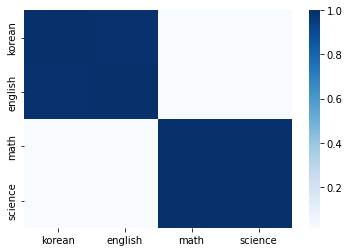

In [59]:
sns.heatmap(fullscore.corr(), cmap = "Blues") #공선상에 있는 것이 많아지면 곤란해짐

In [60]:
from sklearn.preprocessing import StandardScaler #데이터 스케일링
from sklearn.decomposition import PCA #PCA 패키지
Scaler = StandardScaler()
score_scaled = Scaler.fit_transform(fullscore)
score_scaled

array([[ 1.65590842,  1.56662148, -0.29808657, -0.30752536],
       [ 0.11505306,  0.043407  , -0.48498188, -0.45882161],
       [-0.14526513, -0.0273114 ,  1.0260727 ,  0.93404694],
       ...,
       [-0.67680413, -0.56069229,  1.27824992,  1.27452848],
       [ 0.15308844,  0.12582921, -0.62494159, -0.59870924],
       [ 0.35109006,  0.37578592,  0.81285647,  0.85268678]])

In [61]:
pca = PCA(n_components = 2) #주성분의 개수 - "언어, 수리과학"
pca.fit(score_scaled) 
score_pca = pca.transform(score_scaled) 
print(score_pca.shape) #데이터의 개수는 똑같으면서 components (주성분)의 개수만 2개가 됨 - 차원 낮추기 성공

(1000, 2)


In [62]:
pca.explained_variance_ratio_ 
#분산비에 대한 해석
#1번째 component로 전체 데이터의 분산을 52% 설명
#2번째 component로 전체 데이터 분산을 47% 설명할 수 있다는 것. 
#단 두 개의 component로 원본 데이터의 100%를 설명할 수 있다

array([0.50723952, 0.49122704])

In [63]:
#components의 개수 역시 하이퍼파라미터 - 우리가 판단해서 정해야 함.
#scree plot, 기여율, 고윳값, 모델 성능 등 다양한 기준으로 판단할 수 있음
#누적 기여율 차원

for i in range(1, 4): 
  score_scaled = Scaler.fit_transform(fullscore)
  pca = PCA(n_components = i) 
  pca.fit(score_scaled)
  score_pca = pca.transform(score_scaled)
  print(i, "개의 components로 분석한 분산비:", pca.explained_variance_ratio_)

1 개의 components로 분석한 분산비: [0.50723952]
2 개의 components로 분석한 분산비: [0.50723952 0.49122704]
3 개의 components로 분석한 분산비: [0.50723952 0.49122704 0.00125861]


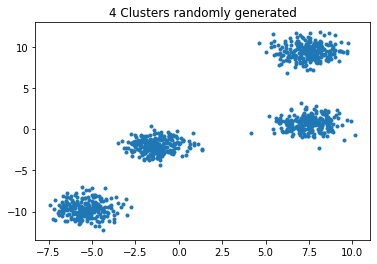

In [64]:
#군집화
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
np.random.seed(8)
X, y = make_blobs(n_samples= 1000, centers = 4, cluster_std = 0.9)
plt.scatter(X[:, 0], X[:, 1], marker = ".")
plt.title("4 Clusters randomly generated")
plt.show()

In [65]:
def distance(a, b):
  return sum((a-b)**2)/len(a)

def group_center(g):
  g = np.array(g)
  return g.mean(axis = 0)

def cluster(x, k, seed = 2022, iter_num = 25):
  logs = []
  np.random.seed(seed)
  centers = x[np.random.choice(len(x), size = k, replace=False)]
  for it in range(iter_num):
    group = {}
    for i in range(k):
      group[i] = []
    # find nearest center
    for row in x:
      temp = []
      for i in range(k):
        temp.append(distance(centers[i], row))
      group[np.argmin(temp)].append(row.tolist())

    # plot data store
    for i in range(k):
      group_temp = np.array(group[i])
      group_temp = np.c_[group_temp, np.full(len(group_temp), i)]
      if i == 0:
        grouped = group_temp
      else:
        grouped = np.append(grouped, group_temp, axis = 0)

    # update center
    centers_new = []
    for i in range(k):
      centers_new.append(group_center(group[i]).tolist())
    centers_new = np.array(centers_new)
    # if updated center == center, break

    if np.sum(centers - centers_new) == 0:
      break
    else:
      centers = centers_new
      logs.append(grouped)
  return grouped, logs, it  

grouped, logs, it = cluster(X, 4)
print(f'iter num:{it}')

iter num:1


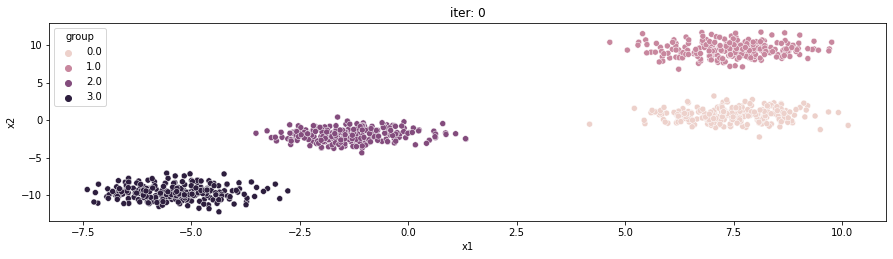

In [66]:
import seaborn as sns
plt.figure(figsize=(15,8))
for i in range(it):
    plt.subplot(2, it//2+1, i+1)  # row, col, index
    df = pd.DataFrame(logs[i])
    df.columns = ['x1', 'x2', 'group']
    sns.scatterplot(data = df, x = 'x1', y = 'x2', hue = 'group').set_title(f'iter: {i}')

In [67]:
#라이브러리 활용
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
iris = load_iris() #iris 데이터 불러오기
irisDF = pd.DataFrame(data = iris.data, columns = ["sepal_length", "sepal_width", "petal_length", "petal_width"])
irisDF.head(3)
#붓꽃 데이터의 정보를 4가지 feature로 정리한 데이터셋- 정답 레이블 없음
#우리의 목적은 irisDF내에 있는 수많은 데이터포인트(붓꽃)들을 비슷한 것끼리 묶는 것
#총 3개의 종류가 있다는 것을 알고 있음

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [68]:
kmeans = KMeans(n_clusters = 3, init = "k-means++", max_iter = 300, random_state = 0) 
kmeans.fit(irisDF)
#init은 초기 cluster point를 어떻게 설정할 것이냐에 관한 것
#k-means++는 기존 kmeans에서 제공하는 경험적 포인트 위치 - 'random'으로 쓰면 랜덤 포인트로 설정함.
#max_iter 는 최대 반복횟수 - 즉 얼마나 많이 클러스터 중점을 옮길 것이냐에 관한 것

KMeans(n_clusters=3, random_state=0)

In [69]:
print(kmeans.labels_)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 0 2 2 2 2
 2 2 0 0 2 2 2 2 0 2 0 2 0 2 2 0 0 2 2 2 2 2 0 2 2 2 2 0 2 2 2 0 2 2 2 0 2
 2 0]


In [70]:
irisDF["target"] = iris.target #실제 데이터셋에 이미 0, 1, 2로 분류해 놓은 붓꽃 품종이 있음. 군집화 성능평가를 위해 위에서는 없는 척함
irisDF["cluster"] = kmeans.labels_ #군집화 모델링을 통해 얻어낸 라벨 - 라벨이 target과 일치하면 우리의 군집화 성능이 뛰어나다고 판단
iris_result = irisDF.groupby(["target", "cluster"])["sepal_length"].count() 
print(iris_result)
#결과를 해석하면 target이 0인 건 1인 케이스도 어느 정도 잘 되었으나, target이 2인 케이스는 군집화가 썩 잘 되지 않았다는 것을 확인할 수 있음. 

target  cluster
0       1          50
1       0          48
        2           2
2       0          14
        2          36
Name: sepal_length, dtype: int64


In [71]:
irisDF.head()

,sepal_length,sepal_width,petal_length,petal_width,target,cluster
0,5.1,3.5,1.4,0.2,0,1
1,4.9,3.0,1.4,0.2,0,1
2,4.7,3.2,1.3,0.2,0,1
3,4.6,3.1,1.5,0.2,0,1
4,5.0,3.6,1.4,0.2,0,1


In [72]:
from sklearn.metrics import silhouette_score
 
#1일 때 제일 좋고 -1일 때 제일 나쁨
labels = kmeans.labels_
silhouette_score(irisDF.iloc[:, :-2], labels, metric='euclidean')

0.5528190123564095

In [73]:
for i in range(2, 4):
  kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, random_state = 0) 
  kmeans.fit(irisDF)
  labels = kmeans.labels_
  print(i, "개 클러스터일 때의 실루엣 계수는: ", silhouette_score(irisDF.iloc[:, :-2], labels, metric = "euclidean"))

#2개로 나누는 것이 제일좋음

2 개 클러스터일 때의 실루엣 계수는:  0.6857881712617192
3 개 클러스터일 때의 실루엣 계수는:  0.5528190123564095


## 1. https://www.notion.so/deepdaiv/4efbe5caadfc44758b978a594fcdf486?pvs=4#aa4f126b43f242f6866aa2d4c3eb0090 에서 CC General 데이터셋을 다운받고 데이터프레임 형식으로 만들어라.

In [3]:
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/CC GENERAL.csv")

In [4]:
#이 데이터셋은 소비자층 분류를 통해 마케팅 전략을 짜기 위한 정보를 담고 있다. 
#약 9000명 정도의 소비자들의 정보가 담겨 있으며, 자세한 컬럼 설명은 아래에 있다.
"""
CUSTID: Identification of Credit Cardholder (Categorical)
BALANCE: Balance amount left in their account to make purchases
BALANCEFREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
PURCHASES: Amount of purchases made from the account
ONEOFFPURCHASES: Maximum purchase amount did in one-go
INSTALLMENTSPURCHASES: Amount of purchase done in installment
CASH ADVANCE: Cash in advance given by the user
PURCHASESFREQUENCY: How frequently the Purchases are being made score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
ONEOFFPURCHASESFREQUENCY: How frequently Purchases are happening in one go (1 = frequently purchased, 0 = not frequently purchased)
PURCHASESINSTALLMENTSFREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
CASHADVANCEFREQUENCY: How frequently is the cash in advance being paid
CASHADVANCETRX: Number of Transactions made with "Cash in Advanced"
PURCHASESTRX: Number of purchase transactions made
CREDIT LIMIT: Limit of Credit Card for user
PAYMENTS: Amount of Payment done by the user
MINIMUM_PAYMENTS: Minimum amount of payments made by the user
PRCFULLPAYMENT: Percent of full payment paid by the user
TENURE: Tenure of credit card service for user
"""

'\nCUSTID: Identification of Credit Cardholder (Categorical)\nBALANCE: Balance amount left in their account to make purchases\nBALANCEFREQUENCY: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)\nPURCHASES: Amount of purchases made from the account\nONEOFFPURCHASES: Maximum purchase amount did in one-go\nINSTALLMENTSPURCHASES: Amount of purchase done in installment\nCASH ADVANCE: Cash in advance given by the user\nPURCHASESFREQUENCY: How frequently the Purchases are being made score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)\nONEOFFPURCHASESFREQUENCY: How frequently Purchases are happening in one go (1 = frequently purchased, 0 = not frequently purchased)\nPURCHASESINSTALLMENTSFREQUENCY: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)\nCASHADVANCEFREQUENCY: How frequently is the cash in advance being paid\nCASHADVANCETRX: Number of Transac

# 2. info와 describe 등으로 데이터의 형태를 파악하라. 또한 데이터의 결측치를 확인하고 대체한 뒤 대체 방식의 근거를 제시하라.

In [5]:
df.info() #float 위주의 데이터로 구성, int 3개 object 1개 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [6]:
#describe 확인
df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [7]:
#결측치 확인
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [8]:
#CREDIT_LIMIT 부분 결측치 단 한 개 -> 확인해보자

In [9]:
df["CREDIT_LIMIT"].describe()

count     8949.000000
mean      4494.449450
std       3638.815725
min         50.000000
25%       1600.000000
50%       3000.000000
75%       6500.000000
max      30000.000000
Name: CREDIT_LIMIT, dtype: float64

<AxesSubplot:ylabel='CREDIT_LIMIT'>

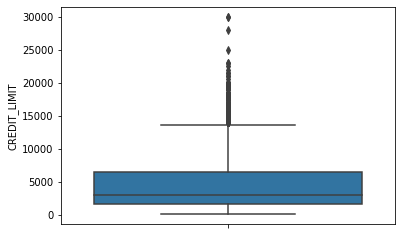

In [10]:
#최대 최소간 차이가 생각보다 크다. 시각화로 확인
sns.boxplot(y = "CREDIT_LIMIT", data = df)
# 이상치가 많은 걸 봐서는 평균 같은 건 결측치를 대표하지 못할듯. 그럼 최빈값으로 대체하자

In [11]:
df["CREDIT_LIMIT"].mode()

0    3000.0
dtype: float64

In [12]:
df["CREDIT_LIMIT"] = df["CREDIT_LIMIT"].fillna(df["CREDIT_LIMIT"].mode().iloc[0])

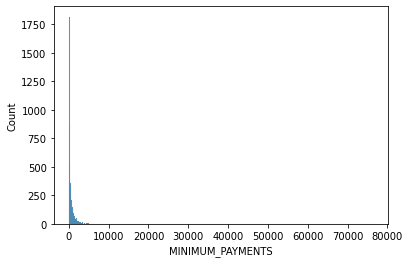

In [13]:
#MINIMUM_PAYMENTS 해결
#개수가 313개나 된다. 시각화를 해보자.
sns.histplot(x = "MINIMUM_PAYMENTS", data = df)
plt.show()
#이친구 역시도 최빈값을 이용하는 편이 좋을 것 같다.

<AxesSubplot:ylabel='MINIMUM_PAYMENTS'>

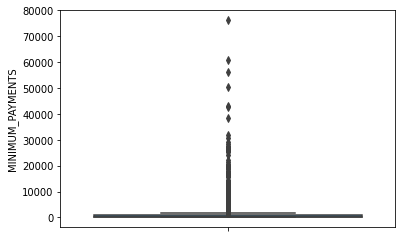

In [14]:
#그래도 한번 더 시각화
sns.boxplot(y = 'MINIMUM_PAYMENTS', data = df)
#역시 최빈값으로 대체하는 게 맞겠다.

In [15]:
df["MINIMUM_PAYMENTS"] = df["MINIMUM_PAYMENTS"].fillna(df["MINIMUM_PAYMENTS"].mode().iloc[0])

In [16]:
df.isnull().sum() #처리 끝.

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

# 3. 상관관계를 히트맵으로 그리고 높은 상관관계를 보이는 변수들을 찾아라.

In [17]:
corr_df = df.corr()

In [18]:
"""
절댓값 0.5 이상인 것 기준으로 찾기
balance-cash advance
balance-credit limit
purchases - oneoff-purchases 0.92!!!.
purchases - installments-purchases
purchases - oneoff purchases frequency
purchases - purchases-trx
purchases - payments
oneoff purchases - oneoff purchases frequency
oneoff purchases - purchases-trx
oneoff purchases - payments
installments purchases - purchases installments frequency
installments purchases - purchases trx
cash advance - cash advance frequency
cash advance - cash advance trx
purchases frequency - oneoff purchases frequency
purchases frequency - purchases installments frequency 0.86!!
purchases frequecny - purchases trx
oneoff purchases frequency - purchases trx
purchasements install frequency - purchases trx
cash advance frequency - cash advance trx
"""

'\n절댓값 0.5 이상인 것 기준으로 찾기\nbalance-cash advance\nbalance-credit limit\npurchases - oneoff-purchases 0.92!!!.\npurchases - installments-purchases\npurchases - oneoff purchases frequency\npurchases - purchases-trx\npurchases - payments\noneoff purchases - oneoff purchases frequency\noneoff purchases - purchases-trx\noneoff purchases - payments\ninstallments purchases - purchases installments frequency\ninstallments purchases - purchases trx\ncash advance - cash advance frequency\ncash advance - cash advance trx\npurchases frequency - oneoff purchases frequency\npurchases frequency - purchases installments frequency 0.86!!\npurchases frequecny - purchases trx\noneoff purchases frequency - purchases trx\npurchasements install frequency - purchases trx\ncash advance frequency - cash advance trx\n'

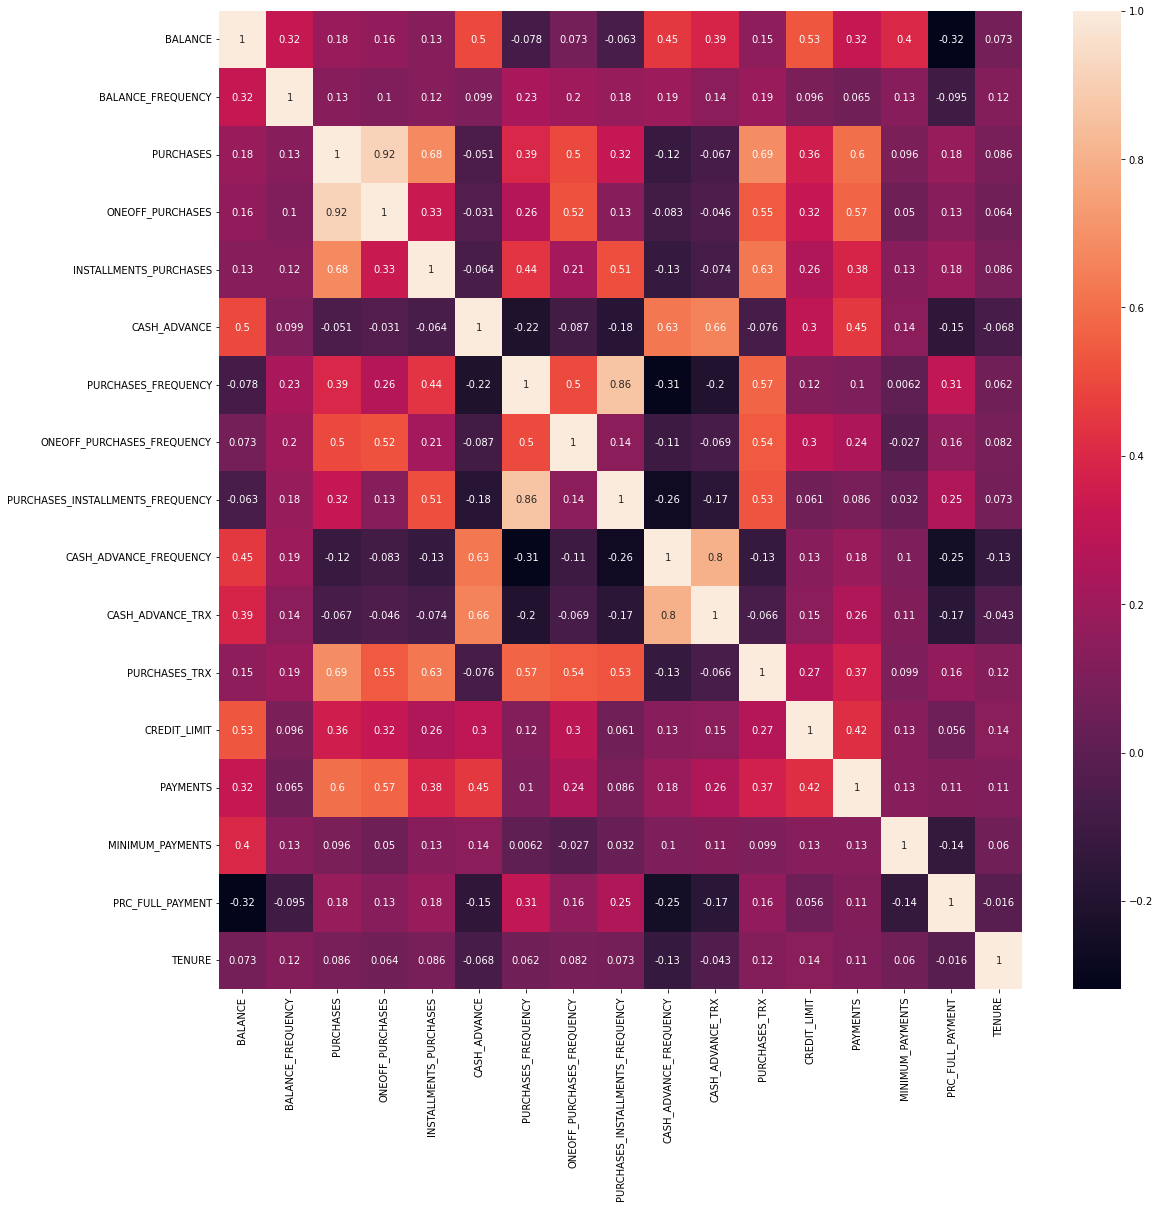

In [19]:
ax = plt.figure(figsize = (18, 18))
sns.heatmap(corr_df, annot = True, annot_kws = {'size':10})
plt.show()

# 4. 3가지의 각기 다른 인사이트를 담은 시각화를 수행하라.

In [20]:
# 1. 자주 결제하는 사람일수록 한번에 결제하는 양이 적을 것이다. --> 편차가 크지만 생각보다 결제를 자주하면 한번에 결제하는 금액도 높다

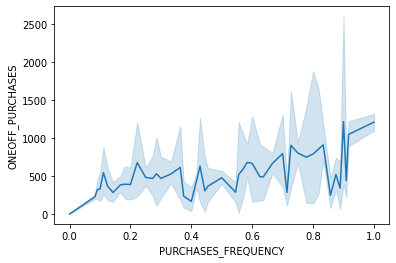

In [27]:
sns.lineplot(x = 'PURCHASES_FREQUENCY', y = 'ONEOFF_PURCHASES', data = df)
plt.show()

In [28]:
# 2. 신용카드 limit 이 고액인 사람일 수록 소비를 더 쉽게 한다 - 많은 금액 사용 --> 편차가 크지만 그런 경향이 실제로 있다.

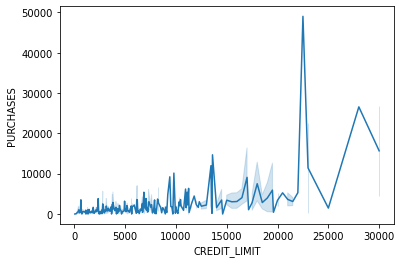

In [31]:
sns.lineplot(x = 'CREDIT_LIMIT', y = 'PURCHASES', data = df)
plt.show()

In [ ]:
# 3. 분할결제를 자주 하는 사람은 분할결제하는 양이 많을 것이다. --> 아주 살짝 그렇긴 하지만 변화가 크지 않다. 빈도가 0.8일때에서 편차가 좀 보인다.

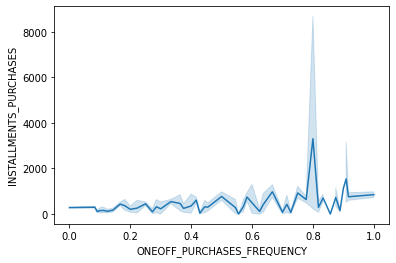

In [41]:
sns.lineplot(x = 'ONEOFF_PURCHASES_FREQUENCY', y = 'INSTALLMENTS_PURCHASES', data = df)
plt.show()

# 5. PCA를 활용해 차원 축소를 해 보아라. 단, n_components가 5인 경우, 10인 경우, 15인 경우를 비교하고 분산비의 차원에서 몇 개의 components를 사용하는 것이 가장 합리적인지 제안하고 그 근거를 제시하라.

In [ ]:
#일단 object column 제거를 하자.
df = df.drop(["CUST_ID"], axis = 1)

In [ ]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
Scaler = StandardScaler()
df_scaled = Scaler.fit_transform(df)
df_scaled

array([[-0.73198937, -0.24943448, -0.42489974, ..., -0.30219162,
        -0.52555097,  0.36067954],
       [ 0.78696085,  0.13432467, -0.46955188, ...,  0.09768992,
         0.2342269 ,  0.36067954],
       [ 0.44713513,  0.51808382, -0.10766823, ..., -0.09309443,
        -0.52555097,  0.36067954],
       ...,
       [-0.7403981 , -0.18547673, -0.40196519, ..., -0.32666531,
         0.32919999, -4.12276757],
       [-0.74517423, -0.18547673, -0.46955188, ..., -0.33809497,
         0.32919999, -4.12276757],
       [-0.57257511, -0.88903307,  0.04214581, ..., -0.32414873,
        -0.52555097, -4.12276757]])

In [ ]:
for i in [5, 10, 15]: 
  df_scaled = Scaler.fit_transform(df)
  pca = PCA(n_components = i) 
  pca.fit(df_scaled)
  df_pca = pca.transform(df_scaled)
  print(i, "개의 components로 분석한 분산비 : ", pca.explained_variance_ratio_)

5 개의 components로 분석한 분산비 :  [0.27297845 0.20314038 0.0881369  0.07479505 0.06223863]
10 개의 components로 분석한 분산비 :  [0.27297845 0.20314038 0.0881369  0.07479505 0.06223864 0.0573979
 0.04883349 0.04300227 0.03797499 0.03080003]
15 개의 components로 분석한 분산비 :  [0.27297845 0.20314038 0.0881369  0.07479505 0.06223864 0.0573979
 0.04883349 0.04300227 0.03797499 0.03080003 0.02372259 0.01773367
 0.01427893 0.01216909 0.0101266 ]


In [ ]:
print("5개일 때: ", 0.27297845 + 0.20314038 + 0.0881369 + 0.07479505 + 0.06223863)
print("10개일 때: ", 0.27297845+0.20314038+0.0881369 + 0.07479505+ 0.06223864 +0.0573979+ 0.04883349+ 0.04300227+ 0.03797499 +0.03080003)
print("15개일 때: ", 0.27297845 + 0.20314038+ 0.0881369+  0.07479505 +0.06223864 +0.0573979+ 0.04883349+0.04300227+ 0.03797499 +0.03080003+ 0.02372259+0.01773367+ 0.01427893+ 0.01216909 +0.0101266)

5개일 때:  0.7012894099999999
10개일 때:  0.9192981
15개일 때:  0.99732898


In [ ]:
#15개일 때 손실률이 가장 적으므로 15개의 component를 사용하는 것이 합리적이다.

# 6. 5번의 결과로 PCA된 데이터에 Kmeans Clustering을 해보고 Silhouette score를 활용해 최적의 K를 정하라.

In [ ]:
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [ ]:
df_scaled = Scaler.fit_transform(df)
pca = PCA(n_components = 15) 
pca.fit(df_scaled)
df_pca = pca.transform(df_scaled)

In [ ]:
for i in range(2, 16):
  kmeans = KMeans(n_clusters = i, init = "k-means++", max_iter = 300, random_state = 144) 
  kmeans.fit(df_pca)
  labels = kmeans.labels_
  print(i, "개 클러스터일 때의 실루엣 계수는: ", silhouette_score(df, labels, metric = "euclidean"))

2 개 클러스터일 때의 실루엣 계수는:  0.07704512399905607
3 개 클러스터일 때의 실루엣 계수는:  0.341305335796574
4 개 클러스터일 때의 실루엣 계수는:  0.043368244159560886
5 개 클러스터일 때의 실루엣 계수는:  0.0008787539879403386
6 개 클러스터일 때의 실루엣 계수는:  0.005269320436240243
7 개 클러스터일 때의 실루엣 계수는:  -0.060784311814007376
8 개 클러스터일 때의 실루엣 계수는:  -0.067115309433489
9 개 클러스터일 때의 실루엣 계수는:  -0.053462768269686156
10 개 클러스터일 때의 실루엣 계수는:  -0.042095027715090286
11 개 클러스터일 때의 실루엣 계수는:  -0.05496291222536598
12 개 클러스터일 때의 실루엣 계수는:  -0.06266427808241917
13 개 클러스터일 때의 실루엣 계수는:  -0.0594209243494076
14 개 클러스터일 때의 실루엣 계수는:  -0.06531473678454609
15 개 클러스터일 때의 실루엣 계수는:  -0.05951581879048532


In [ ]:
#실루엣 계수가 1에 가까울 수록 좋은 것이므로, K=3인 것이 가장 적절하다.